### Import the Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

## Import the Data

In [2]:
# JSON file
f = open ('attributes.json', "r")
  
# Reading from file
data = json.loads(f.read())
df=pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,upgraded_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   upgraded_user           50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## attributes.json
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips.
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* upgraded_user: TRUE if the user took an upgraded ride in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

In [4]:
# Drop the duplicate rows
df=df.drop_duplicates()

In [5]:
## Converting to Datetime
df['signup_date']=pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df['last_trip_date']=pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  object        
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    41873 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   last_trip_date          49992 non-null  datetime64[ns]
 6   phone                   49596 non-null  object        
 7   surge_pct               49992 non-null  float64       
 8   upgraded_user           49992 non-null  bool          
 9   weekday_pct             49992 non-null  float64       
 10  avg_dist                49992 non-null  float64       
 11  avg_rating_by_driver    49791 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [6]:
# Check the Max and Min Date
df['signup_date'].min(), df['signup_date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-01-31 00:00:00'))

All the users signed up in the month of January

In [7]:
# Check the Max and Min Date
df['last_trip_date'].min(), df['last_trip_date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

We have users who made their last trip on the sign up date and also have users who are active also in the 6th month

In [8]:
def get_active_users(df,num_of_days):
    maxi=df['last_trip_date'].max()
    active=[]
    for last in df['last_trip_date']:
        if last>=maxi-pd.to_timedelta(num_of_days, unit='D'):
            active.append(1)
        else:
            active.append(0)
    return active

In [9]:
df['active']=get_active_users(df,30) #It is considered active when they made their last trip in the preceding 30 days from the Maximum day

This would also give us the users who were acrive during the 6th month fromthe sign up date which would used for our classification model in Question 2)

In [10]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,upgraded_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [11]:
# Percentage of Both the Classes
df['active'].value_counts(normalize=True)

0    0.62386
1    0.37614
Name: active, dtype: float64

We can see there are 37.6% users who are active and the remaining are inactive

In [12]:
# Missing Data Percentage

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
avg_rating_of_driver,8119,16.240598
phone,396,0.792127
avg_rating_by_driver,201,0.402064
city,0,0.000000
trips_in_first_30_days,0,0.000000
signup_date,0,0.000000
avg_surge,0,0.000000
last_trip_date,0,0.000000
surge_pct,0,0.000000
upgraded_user,0,0.000000


We could go ahead and remove the avg_rating_of_driver field but that from my intuition says that it could be an important feature as the drivers sticking with the app has a direct relationship with their satisfaction on their uber drivers and rides.

So we can go ahead and impute them.

In [13]:
#Imputing with Median for Numeric Variables

df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())

In [14]:
df['phone'].value_counts(normalize=True)

iPhone     0.697193
Android    0.302807
Name: phone, dtype: float64

We would go ahead and impute the missing ones with the mode(Most Freuqently used- In this case it is IPhone)

In [15]:
# Replacing with the Mode
df['phone'] = df['phone'].fillna(df['phone'].mode().iloc[0])

In [16]:
# Missing Data Percentage

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
city,0,0.0
trips_in_first_30_days,0,0.0
signup_date,0,0.0
avg_rating_of_driver,0,0.0
avg_surge,0,0.0
last_trip_date,0,0.0
phone,0,0.0
surge_pct,0,0.0
upgraded_user,0,0.0
weekday_pct,0,0.0


Now there are no missing values in the dataset

## Exploratory Data Analysis

### Numerical Features

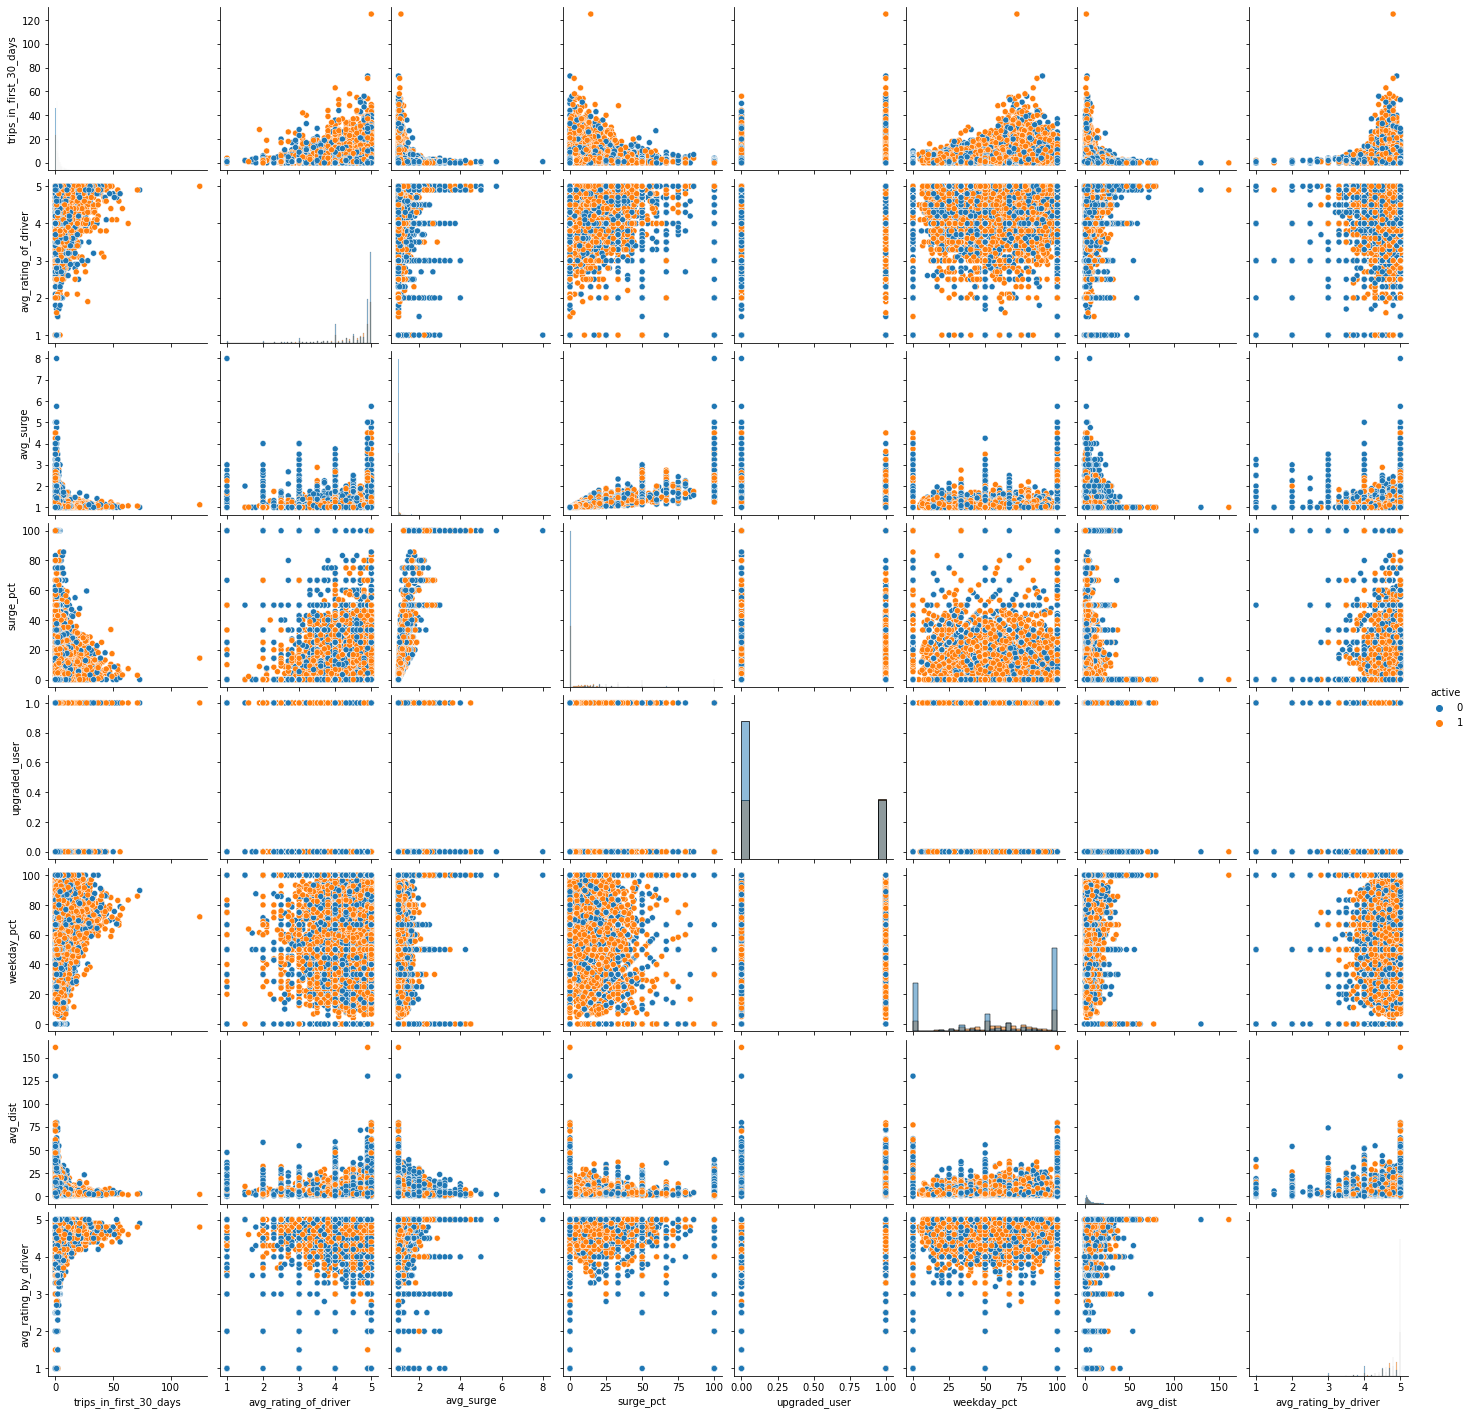

In [17]:
sns.pairplot(df, hue='active',diag_kind="hist")

At a high level, we can see there are a lot of anomalies which needs to be removed. But before that let's explore in depth the following numerical features, 

* Trips in first 30 days (Anomalies and Patterns)
* Avg Distance(Anomalies and Patterns)
* Avg Surge (Anomalies and Patterns)
* Avg Rating of Driver (Patterns)
* Weekday Percent (Patterns)
* Avg Rating of Driver (Patterns)
* Avg Rating By Driver (Patterns)

For other features, there seem to be not much obvious patterns

In [18]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'upgraded_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active'],
      dtype='object')

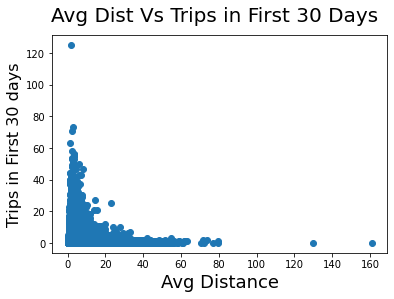

In [19]:
fig = plt.figure()
plt.scatter(df['avg_dist'], df['trips_in_first_30_days'])
fig.suptitle('Avg Dist Vs Trips in First 30 Days', fontsize=20)
plt.xlabel('Avg Distance', fontsize=18)
plt.ylabel('Trips in First 30 days', fontsize=16)
plt.show()

There are certainly outliers where we can see even when the Avg Distance is 0, the trips travelled in first 30 days is very high

In [20]:
df[(df['avg_dist']==0.0) & (df['trips_in_first_30_days']>0)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,upgraded_user,weekday_pct,avg_dist,avg_rating_by_driver,active
72,Astapor,1,2014-01-07,5.0,1.00,2014-01-08,iPhone,0.0,False,100.0,0.0,3.0,0
116,Winterfell,1,2014-01-10,5.0,1.00,2014-01-11,Android,0.0,False,100.0,0.0,5.0,0
188,Winterfell,1,2014-01-11,4.9,1.00,2014-01-14,Android,0.0,False,100.0,0.0,5.0,0
356,Winterfell,1,2014-01-15,4.0,1.00,2014-01-16,Android,0.0,False,100.0,0.0,5.0,0
479,Winterfell,1,2014-01-24,5.0,1.00,2014-01-25,iPhone,0.0,False,0.0,0.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46786,Astapor,1,2014-01-21,4.9,1.00,2014-02-04,iPhone,0.0,False,100.0,0.0,2.0,0
46948,King's Landing,2,2014-01-10,5.0,1.75,2014-06-29,iPhone,100.0,True,0.0,0.0,5.0,1
47854,Winterfell,1,2014-01-06,4.9,1.00,2014-01-07,iPhone,0.0,False,100.0,0.0,5.0,0
49989,Winterfell,1,2014-01-24,4.9,1.00,2014-01-31,iPhone,0.0,False,100.0,0.0,5.0,0


The trips in first 30 days cannot be greater than 0 if their avg travelled distance is 0. If their avg distance is 0 in first 30 days, it means they have not travelled and the trips should be 0. So I am assuming they could be anomalies. So removing these values.

In [21]:
df=df[~((df['avg_dist']==0.0) & (df['trips_in_first_30_days']>0))]

Same applies the other way round

In [22]:
df[((df['avg_dist']>0.0) & (df['trips_in_first_30_days']==0))]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,upgraded_user,weekday_pct,avg_dist,avg_rating_by_driver,active
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
13,King's Landing,0,2014-01-29,4.0,1.38,2014-06-08,iPhone,50.0,False,50.0,3.04,5.0,1
17,King's Landing,0,2014-01-12,3.9,1.00,2014-07-01,iPhone,0.0,True,95.2,2.38,4.8,1
19,King's Landing,0,2014-01-02,5.0,1.17,2014-06-03,iPhone,33.3,False,66.7,12.08,5.0,1
22,Winterfell,0,2014-01-24,4.9,1.00,2014-05-02,iPhone,0.0,False,100.0,11.47,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49986,Winterfell,0,2014-01-21,4.0,1.00,2014-05-23,Android,0.0,False,100.0,0.52,5.0,0
49991,Winterfell,0,2014-01-08,5.0,1.25,2014-06-29,iPhone,100.0,False,0.0,1.06,5.0,1
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0


If the trips in the first 30 days are zero, then it means the avg distance cannot be greater than 0 for the first 30 days. This would drop about 30% of the data

In [23]:
df=df[~((df['avg_dist']>0.0) & (df['trips_in_first_30_days']==0))]
df.shape

(34565, 13)

This brings down the overall dataframe to 34565 rows. Now we can remove the extremely high values.

In [24]:
df=df[(df['avg_dist']<=65) & (df['trips_in_first_30_days']<=70)]
df.shape

(34558, 13)

THis removed a few rows from the dataset

We also have an avg_surge value which is extremely high compared to others. Let's examine that!

In [25]:
df[df['avg_surge']>6]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,upgraded_user,weekday_pct,avg_dist,avg_rating_by_driver,active
13861,Winterfell,1,2014-01-01,1.0,8.0,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0,0


Again this is really skewed compared to tothers and hence we ignore that row

In [26]:
df=df[df['avg_surge']<=6]
df.shape

(34557, 13)

In [27]:
df.describe()  #Making sure everything looks good like non-negative values, percents greater than 100 etc.

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active
count,34557.000000,34557.000000,34557.000000,34557.000000,34557.000000,34557.000000,34557.000000,34557.000000
mean,3.285326,4.628249,1.076125,9.009599,60.767995,5.528363,4.773383,0.382817
std,4.095524,0.572604,0.211257,18.984142,35.009843,5.228596,0.418928,0.486081
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,4.500000,1.000000,0.000000,37.500000,2.460000,4.700000,0.000000
50%,2.000000,4.900000,1.000000,0.000000,66.700000,3.800000,5.000000,0.000000
75%,4.000000,5.000000,1.070000,10.900000,100.000000,6.520000,5.000000,1.000000
max,63.000000,5.000000,5.750000,100.000000,100.000000,63.150000,5.000000,1.000000


### Plot features to Examine potential Patterns

Let's plot Avg rating of driver Vs the Trips in the first 30 days

<AxesSubplot:xlabel='avg_rating_of_driver', ylabel='trips_in_first_30_days'>

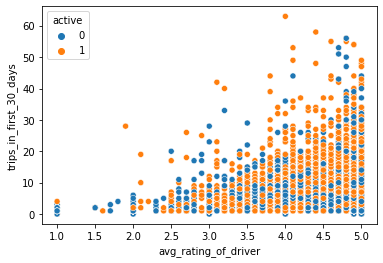

In [28]:
sns.scatterplot(data=df, x="avg_rating_of_driver", y="trips_in_first_30_days", hue="active")

We can see that the people who have travelled more in the First 30 days gave a higher rating for their driver. Also we can see a lot of active people who gave higher rating of their driver.

This tells that if the riders are satisfied with their drivers, then they performed on average more number of trips and also tend to remain active. Let's examine this further below.

<AxesSubplot:xlabel='active', ylabel='trips_in_first_30_days'>

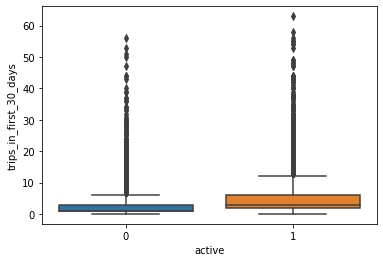

In [29]:
sns.boxplot(x="active", y="trips_in_first_30_days", data=df)

We can say that on average if the users take more trips in the first 30 days, they tend to remain active for the most cases.

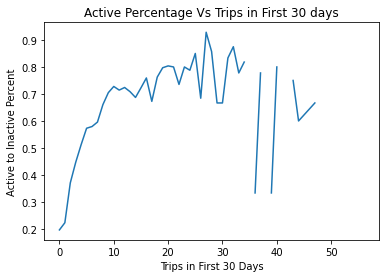

In [30]:
trips_df=pd.pivot_table(data=df, columns=['active'], index='trips_in_first_30_days', values='city',aggfunc='count')
trips_df['Percent']=trips_df[1]/(trips_df[0]+ trips_df[1])

plt.plot(trips_df['Percent'])
plt.xlabel('Trips in First 30 Days')
plt.ylabel('Active to Inactive Percent')
plt.title('Active Percentage Vs Trips in First 30 days')
plt.show();

We can see that as the trips in first 30 days rise, the active percentage to inactive percentage also seems to rise atleast very rapidly in the beginning. So this indicates that this may be an important feature to consider while modelling.

<AxesSubplot:xlabel='weekday_pct', ylabel='trips_in_first_30_days'>

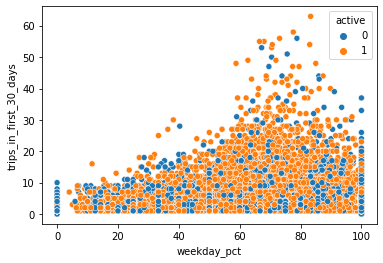

In [31]:
sns.scatterplot(data=df, x="weekday_pct", y="trips_in_first_30_days", hue="active")

This plot shows that the trips taken in the first 30 days is more when people travel more in the weekdays. This is true because more weekdays riders use them regularly for work and hence more trips taken by them.

<AxesSubplot:xlabel='active', ylabel='weekday_pct'>

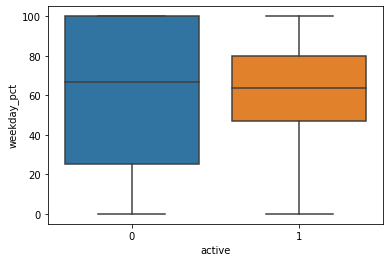

In [32]:
sns.boxplot(x="active", y="weekday_pct", data=df)

We couldnt say much about the inactive riders as they are spread across the days. But the active users in general have an above average weekday percent. But that doesnt mean all high weekday riders would be active.

In [33]:
#Categorical and Boolean Features
df.select_dtypes(include=["object",'bool']).columns

Index(['city', 'phone', 'upgraded_user'], dtype='object')

<AxesSubplot:xlabel='city', ylabel='Count'>

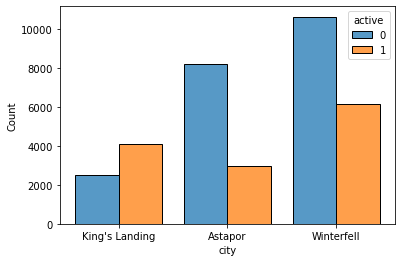

In [34]:
sns.histplot(data=df, x="city", hue="active",multiple="dodge", shrink=.8)

We can see in almost all the cities, the number of inactive riders are more compared to the Active Riders. But in King's Landing, the number of active riders outnumbers the inactive riders.

There could be a number of potential reasons this could happen- maybe more number of offices(more transportation reimbursements), cost of car ownership in King's Landing is higher than ride sharing. etc.

<AxesSubplot:xlabel='city', ylabel='weekday_pct'>

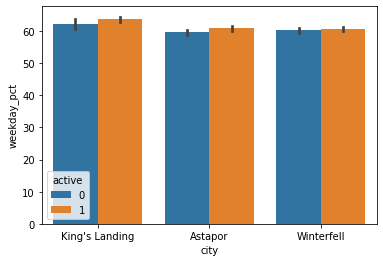

In [35]:
sns.barplot(x="city", y="weekday_pct", hue="active", data=df)

There are more users(active and inactive users) who use the rides in Weekdays in King's Landing compared to other places.

<AxesSubplot:xlabel='phone', ylabel='Count'>

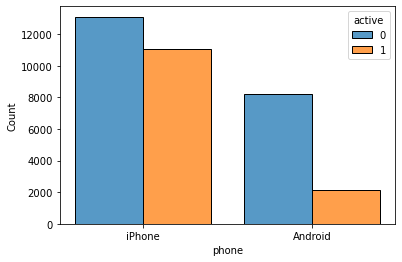

In [36]:
sns.histplot(data=df, x="phone", hue="active",multiple="dodge", shrink=.8)

In [37]:
phone_df=pd.pivot_table(data=df, columns=['active'], index='phone', values='city',aggfunc='count')
phone_df['Percent']=phone_df[1]/(phone_df[0]+ phone_df[1])
phone_df

active,0,1,Percent
phone,,,
Android,8228,2158,0.207780
iPhone,13100,11071,0.458028


When we look at the active user percentage, there are more iphone users compared to the Android users. Maybe the way the application is desinged in Iphone makes people to use them more, or maybe riders face a lot of glitch or app issues with Android that makes them go inactive and churn.

<AxesSubplot:xlabel='upgraded_user', ylabel='Count'>

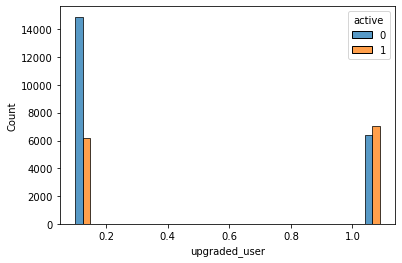

In [38]:
sns.histplot(data=df, x="upgraded_user", hue="active",multiple="dodge", shrink=.8)

In [39]:
upgraded_df=pd.pivot_table(data=df, columns=['active'], index='upgraded_user', values='city',aggfunc='count')
upgraded_df['Percent']=upgraded_df[1]/(upgraded_df[0]+ upgraded_df[1])
upgraded_df

active,0,1,Percent
upgraded_user,,,
False,14901,6193,0.293591
True,6427,7036,0.522618


If a rider has made an upgrade to a luxury car, we can say that there is more than 50% chance that they would be an active rider, whereas if the rider has not upgraded, it means there is only 29.3% chance that they will be active.

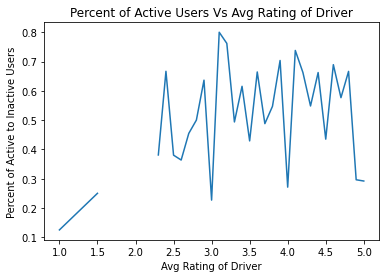

In [40]:
#Avg Rating of Driver

driverrating_df=pd.pivot_table(data=df, columns=['active'], index='avg_rating_of_driver', values='city',aggfunc='count')
driverrating_df['Percent']=driverrating_df[1]/(driverrating_df[0]+ driverrating_df[1])
plt.plot(driverrating_df['Percent'])
plt.xlabel('Avg Rating of Driver')
plt.ylabel('Percent of Active to Inactive Users')
plt.title('Percent of Active Users Vs Avg Rating of Driver')
plt.show();

There is no significant pattern that shows that the percent of Active users would rise with the avg rating of the driver

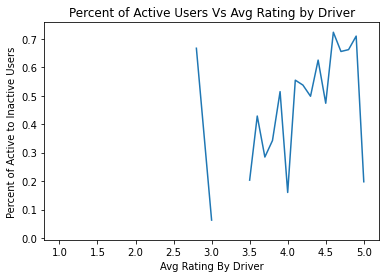

In [41]:
#Avg Rating by Driver

bydriverrating_df=pd.pivot_table(data=df, columns=['active'], index='avg_rating_by_driver', values='city',aggfunc='count')
bydriverrating_df['Percent']=bydriverrating_df[1]/(bydriverrating_df[0]+ bydriverrating_df[1])
plt.plot(bydriverrating_df['Percent'])
plt.xlabel('Avg Rating By Driver')
plt.ylabel('Percent of Active to Inactive Users')
plt.title('Percent of Active Users Vs Avg Rating by Driver')
plt.show();

When the average rating by the driver increases, then there doesnt seem to be a significant increase or decrease in the Active User Percentage. Though there is a slight increase from 3.5 to 4.8, at 5.0 the percent of active users drops which is against our intuition.

### Let's see if there is anything we could learn more about the data

<AxesSubplot:xlabel='signup_date'>

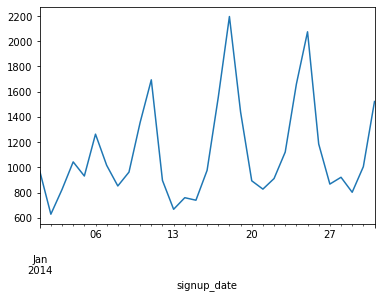

In [42]:
# construct a new df to experiment on the time-series 
df_timestamp = df[['last_trip_date', 'signup_date']].copy()
df_timestamp['count'] = 1
df_timestamp = df_timestamp.set_index('signup_date')
df_timestamp['count'].resample("1D").sum().plot()

The sign up dates are the highest in the mid of January 

<AxesSubplot:xlabel='last_trip_date'>

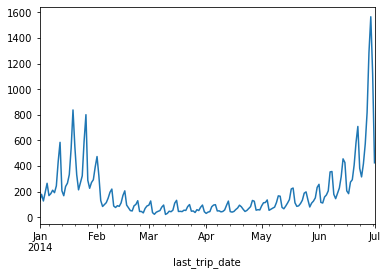

In [43]:
df_timestamp = df_timestamp.set_index('last_trip_date')
df_timestamp['count'].resample("1D").sum().plot()

Counts of last trip date significantly increse. The reason could be that a lot of people use Uber just for travel during summer vaccation, when travel ends, they are not going to use Uber any more because they have cars in their own cities/countries.

Also we could see some significant churns in the beginning after the sign ups. These all could be the people who either didnt like Uber or they bought their own car after that and became inactive

With what we have learned so far about the features, let's see if we could select more relevant features that could help our model

In [44]:
df['active'].value_counts(normalize=True)

0    0.617183
1    0.382817
Name: active, dtype: float64


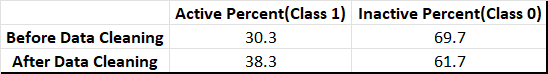

# Feature Selection

## Using Pearson Correlation

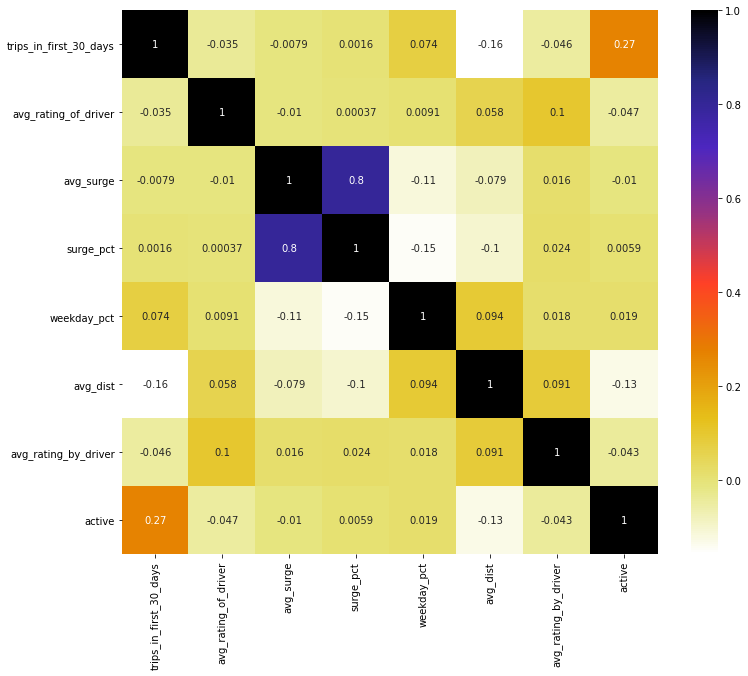

In [45]:

plt.figure(figsize=(12,10))
cor = df.drop('upgraded_user',axis=1).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

### Observations

* We have a high correlation between avg_surge and surge_pct. So we can go ahead and remove any one of the features to prevent from a multicollinearity issue.
* trips_in_first_30_days, upgraded_user, and avg_dist seem to have a high correlation with the Response variable 'active' compared to the other features. So we go ahead and keep those features. 

Let's further examine to see if there are other important features

## Constant Variance Method

In [46]:

objects = ['float64','int32']
newdf = df.select_dtypes(include=objects)

from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(newdf)

VarianceThreshold(threshold=0)

In [47]:
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True])

### Observations

* There are no columns with constant variance.

## Two Sample T Test

In [48]:
objects = ['float64','int32']
newdf = df.select_dtypes(include=objects)
newdf

,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,4.7,1.10,15.4,46.2,3.67,5.0
2,4.3,1.00,0.0,100.0,0.77,5.0
3,4.6,1.14,20.0,80.0,2.36,4.9
4,4.4,1.19,11.8,82.4,3.13,4.9
5,3.5,1.00,0.0,100.0,10.56,5.0
...,...,...,...,...,...,...
49990,4.7,1.08,33.3,33.3,3.38,5.0
49992,1.0,1.00,0.0,0.0,7.58,5.0
49993,4.8,1.11,11.1,55.6,2.53,4.7
49994,4.6,1.44,37.5,25.0,2.25,4.5


In [49]:
# Bulk Performing Two Sample T Test

for i in newdf.columns:
    print('{}:'.format(i),stats.ttest_ind(df[i][df.active==1],df[i][df.active==0]))

avg_rating_of_driver: Ttest_indResult(statistic=-8.784447719104636, pvalue=1.6422359618652247e-18)
avg_surge: Ttest_indResult(statistic=-1.9301555963007586, pvalue=0.053595735447156775)
surge_pct: Ttest_indResult(statistic=1.1053064548942455, pvalue=0.26903451755161145)
weekday_pct: Ttest_indResult(statistic=3.601281697409618, pvalue=0.0003170958204375092)
avg_dist: Ttest_indResult(statistic=-24.232249508549497, pvalue=1.2091196487053566e-128)
avg_rating_by_driver: Ttest_indResult(statistic=-8.021991076323866, pvalue=1.0730427033295847e-15)


### Observations:

* Here the features avg_surge, surge_pct are having a p valeu greater than 0.05 which means they is no significant difference between the sample active=1 and active=0 for these features.
* THe features 'avg_rating_of_driver', 'weekday_pct', 'avg_dist' and 'avg_rating_by_driver' are different in terms of active =0 and active=1

In [50]:
newdf

,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,4.7,1.10,15.4,46.2,3.67,5.0
2,4.3,1.00,0.0,100.0,0.77,5.0
3,4.6,1.14,20.0,80.0,2.36,4.9
4,4.4,1.19,11.8,82.4,3.13,4.9
5,3.5,1.00,0.0,100.0,10.56,5.0
...,...,...,...,...,...,...
49990,4.7,1.08,33.3,33.3,3.38,5.0
49992,1.0,1.00,0.0,0.0,7.58,5.0
49993,4.8,1.11,11.1,55.6,2.53,4.7
49994,4.6,1.44,37.5,25.0,2.25,4.5


In [51]:
y=df['active']

## 1 Way ANOVA

In [52]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
selector.fit(newdf, y)

cols = selector.get_support(indices=True)
cols

array([0, 4, 5], dtype=int64)

In [53]:
selector.scores_

array([ 77.16652173,   3.72550063,   1.22170236,  12.96922986,
       587.20191624,  64.35234083])

In [54]:
newdf.iloc[:,cols]

,avg_rating_of_driver,avg_dist,avg_rating_by_driver
0,4.7,3.67,5.0
2,4.3,0.77,5.0
3,4.6,2.36,4.9
4,4.4,3.13,4.9
5,3.5,10.56,5.0
...,...,...,...
49990,4.7,3.38,5.0
49992,1.0,7.58,5.0
49993,4.8,2.53,4.7
49994,4.6,2.25,4.5


### Observations

* These 3 features 'avg_rating_of_driver', 'avg_dist' and 'avg_rating_by_driver' seem to have a very high scores and hence we can say they are important features when compared to others

## Mutual Information Gain Method

In [55]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
info=[]
for i in range(20):
    mutual_info = mutual_info_classif(newdf, y,random_state=i)
    info.append(mutual_info)
info=np.row_stack(info)

In [56]:
mutual_info = pd.Series(info.mean(axis=0))
mutual_info.index = newdf.columns
mutual_info.sort_values(ascending=False)

weekday_pct             0.166862
avg_rating_by_driver    0.114083
surge_pct               0.113014
avg_surge               0.094931
avg_rating_of_driver    0.048605
avg_dist                0.030284
dtype: float64

<AxesSubplot:>

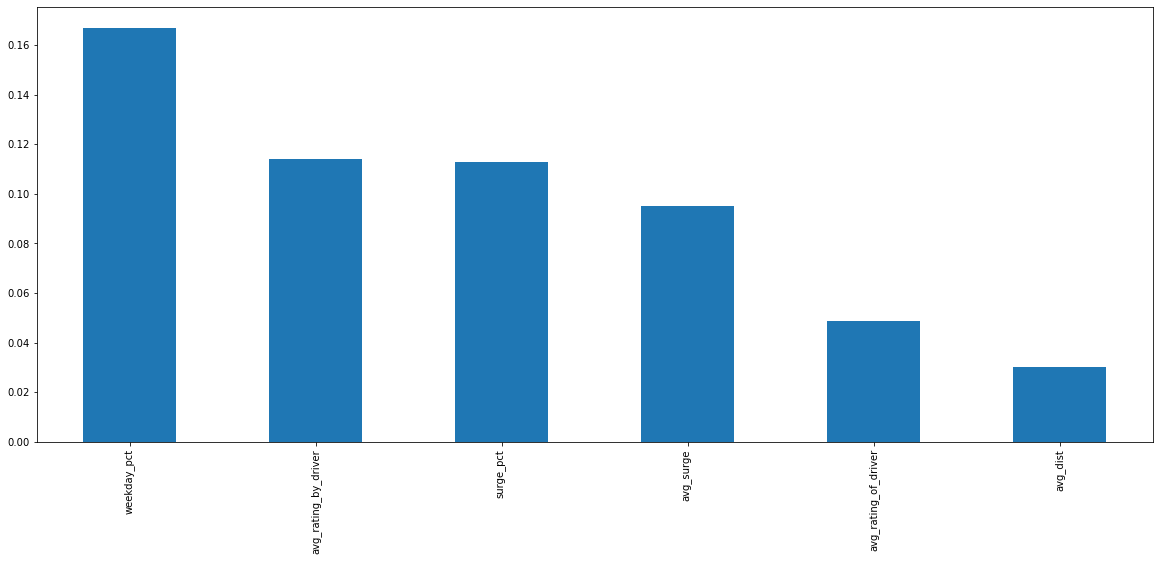

In [57]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

### Observations

* Here 'weekday_pct' seem to have comparitively higher significance than other features.

## Perform Chi Squared Test for Categorical Features

In [58]:
objects = ['object','bool']
newdf = df.select_dtypes(include=objects)

cols=list(newdf.columns)
cols

['city', 'phone', 'upgraded_user']

In [59]:
# Label Encoding these variables

# Import label encoder 
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'Country'. 
for col in cols:
    newdf[col]=label_encoder.fit_transform(newdf[col])

In [60]:
newdf.head()

,city,phone,upgraded_user
0,1,1,1
2,0,1,0
3,1,1,1
4,2,0,0
5,2,1,1


In [61]:
y

0        1
2        0
3        1
4        0
5        1
        ..
49990    0
49992    0
49993    1
49994    0
49998    0
Name: active, Length: 34557, dtype: int64

In [62]:
from sklearn.feature_selection import chi2
f_p_values=chi2(newdf,y)
p_values=pd.Series(f_p_values[1])
p_values.index=newdf.columns
p_values.sort_values(ascending=True)

upgraded_user    3.533697e-244
phone            7.174720e-128
city              3.144716e-25
dtype: float64

### Observation
* Here it looks like all the three categorical features have more significance on the response. 
* The 3 features 'upgraded_user', 'phone' and 'city' are significant features

## Overall Observations

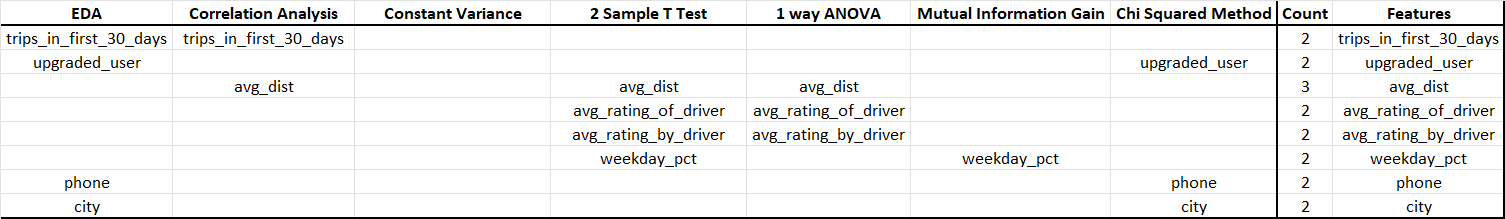

Overall, we can say these Features seems to more dominating in terms of significance compared to the other features. Hence I am choosing those features for the modelling.

**Final Features Selected:**

* trips_in_first_30_days
* upgraded_user
* avg_dist
* avg_rating_of_driver
* avg_rating_by_driver
* weekday_pct
* phone
* city

## Modelling

In [63]:
features_selected=['trips_in_first_30_days','upgraded_user','avg_dist','avg_rating_of_driver','avg_rating_by_driver','weekday_pct','phone','city']
X= df[features_selected]
X

,trips_in_first_30_days,upgraded_user,avg_dist,avg_rating_of_driver,avg_rating_by_driver,weekday_pct,phone,city
0,4,True,3.67,4.7,5.0,46.2,iPhone,King's Landing
2,3,False,0.77,4.3,5.0,100.0,iPhone,Astapor
3,9,True,2.36,4.6,4.9,80.0,iPhone,King's Landing
4,14,False,3.13,4.4,4.9,82.4,Android,Winterfell
5,2,True,10.56,3.5,5.0,100.0,iPhone,Winterfell
...,...,...,...,...,...,...,...,...
49990,1,True,3.38,4.7,5.0,33.3,iPhone,Astapor
49992,1,False,7.58,1.0,5.0,0.0,iPhone,King's Landing
49993,3,True,2.53,4.8,4.7,55.6,iPhone,Astapor
49994,1,False,2.25,4.6,4.5,25.0,iPhone,Astapor


In [64]:
# Convert the Boolean into Integer
X['upgraded_user']=X['upgraded_user'].astype(int)
X

,trips_in_first_30_days,upgraded_user,avg_dist,avg_rating_of_driver,avg_rating_by_driver,weekday_pct,phone,city
0,4,1,3.67,4.7,5.0,46.2,iPhone,King's Landing
2,3,0,0.77,4.3,5.0,100.0,iPhone,Astapor
3,9,1,2.36,4.6,4.9,80.0,iPhone,King's Landing
4,14,0,3.13,4.4,4.9,82.4,Android,Winterfell
5,2,1,10.56,3.5,5.0,100.0,iPhone,Winterfell
...,...,...,...,...,...,...,...,...
49990,1,1,3.38,4.7,5.0,33.3,iPhone,Astapor
49992,1,0,7.58,1.0,5.0,0.0,iPhone,King's Landing
49993,3,1,2.53,4.8,4.7,55.6,iPhone,Astapor
49994,1,0,2.25,4.6,4.5,25.0,iPhone,Astapor


In [65]:
y= df['active']
y

0        1
2        0
3        1
4        0
5        1
        ..
49990    0
49992    0
49993    1
49994    0
49998    0
Name: active, Length: 34557, dtype: int64

In [66]:
y.value_counts(normalize=True)

0    0.617183
1    0.382817
Name: active, dtype: float64

This is an imbalanced dataset and it has to be balanced when building the model

In [67]:
#Split the Data to Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

In [68]:
X_train=pd.get_dummies(X_train,drop_first=True)

X_test=pd.get_dummies(X_test,drop_first=True)

#We want to feed our model with the same columns of the train dataset. The trick is to use the reindex function
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)  

X_train.shape

(27645, 9)

In [69]:
X_train.head()

,trips_in_first_30_days,upgraded_user,avg_dist,avg_rating_of_driver,avg_rating_by_driver,weekday_pct,phone_iPhone,city_King's Landing,city_Winterfell
40919,2,0,6.77,4.5,4.9,54.5,1,0,0
47008,1,1,1.36,4.9,5.0,0.0,1,1,0
6286,6,0,1.45,4.2,5.0,85.7,0,0,0
13374,6,1,1.99,5.0,4.7,83.3,1,1,0
34176,4,0,3.28,5.0,4.6,60.0,0,0,1


In [70]:
X_train.dtypes

trips_in_first_30_days      int64
upgraded_user               int32
avg_dist                  float64
avg_rating_of_driver      float64
avg_rating_by_driver      float64
weekday_pct               float64
phone_iPhone                uint8
city_King's Landing         uint8
city_Winterfell             uint8
dtype: object

In [71]:
objects = ['float64','int64']
newdf = X_train.select_dtypes(include=objects)

cols=list(newdf.columns)
cols

['trips_in_first_30_days',
 'avg_dist',
 'avg_rating_of_driver',
 'avg_rating_by_driver',
 'weekday_pct']

In [72]:
# Standardizing the Numerical Columns

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])
X_train

,trips_in_first_30_days,upgraded_user,avg_dist,avg_rating_of_driver,avg_rating_by_driver,weekday_pct,phone_iPhone,city_King's Landing,city_Winterfell
40919,0.000000,0,0.727273,-0.8,-0.333333,-0.1952,1,0,0
47008,-0.333333,1,-0.601966,0.0,0.000000,-1.0672,1,1,0
6286,1.333333,0,-0.579853,-1.4,0.000000,0.3040,0,0,0
13374,1.333333,1,-0.447174,0.2,-1.000000,0.2656,1,1,0
34176,0.666667,0,-0.130221,0.2,-1.333333,-0.1072,0,0,1
...,...,...,...,...,...,...,...,...,...
6738,1.000000,1,-0.162162,-2.0,0.000000,-0.4560,1,0,1
19554,1.666667,0,0.009828,-2.6,-1.666667,-0.2672,1,0,1
21305,-0.333333,1,0.265356,0.2,0.000000,0.5328,0,1,0
26227,-0.333333,1,2.533170,0.0,0.000000,0.5328,0,0,1


In [73]:
## Libraries for Models

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Cross Validation Scores

In [74]:
clfs=[]
clfs.append(XGBClassifier(random_state=13,eval_metric='mlogloss'))
clfs.append(RandomForestClassifier(random_state=13))
clfs.append(LogisticRegression(random_state=13))
clfs.append(SVC(random_state=13))
clfs.append(KNeighborsClassifier(n_neighbors=3))  #No random_State parameter for this KNeighboursClassifier
clfs.append(DecisionTreeClassifier(random_state=13))
clfs.append(GradientBoostingClassifier(random_state=13))
cv_results=[]
for i in clfs:
    imba_pipeline = make_pipeline(SMOTE(random_state=42,sampling_strategy='minority'), i)
    kf = StratifiedKFold(n_splits=7)
    cv_score=cross_val_score(imba_pipeline, X_train, y_train, scoring='f1', cv=kf)
    mean=np.mean(cv_score)
    std=np.std(cv_score)
    final={'Mean':mean,'Standard Deviation':std,'Classifier':i}
    cv_results.append(final)
    print('{}'.format(str(i)),'Mean:',mean,'StDev:',std)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='mlogloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=13, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None) Mean: 0.7504585303721241 StDev: 0.008757210839745597
RandomForestClassifier(random_state=13) Mean: 0.719718590486085 StDev: 0.008390105802604013
LogisticRegression(random_state=13) Mean: 0.6514756157481015 StDev: 0.0064822230390104325
SVC(random_state=13) Mean: 0.7288896301274838 StDev: 0.006732990771335007
KNeighborsClassifier(n_

In [75]:
cv_result_df=pd.DataFrame(cv_results)
cv_result_df

,Mean,Standard Deviation,Classifier
0,0.750459,0.008757,"XGBClassifier(base_score=None, booster=None, c..."
1,0.719719,0.008390,RandomForestClassifier(random_state=13)
2,0.651476,0.006482,LogisticRegression(random_state=13)
3,0.728890,0.006733,SVC(random_state=13)
4,0.680447,0.012214,KNeighborsClassifier(n_neighbors=3)
5,0.655865,0.013687,DecisionTreeClassifier(random_state=13)
6,0.746032,0.008754,GradientBoostingClassifier(random_state=13)


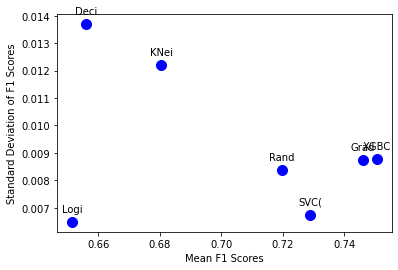

In [76]:
plt.plot(cv_result_df['Mean'],cv_result_df['Standard Deviation'],'bo-',linestyle='None', markersize = 10.0)
for x,y,l in zip(cv_result_df['Mean'],cv_result_df['Standard Deviation'],cv_result_df['Classifier']):
    label = "{}".format(str(l)[:4])

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.xlabel('Mean F1 Scores')
plt.ylabel('Standard Deviation of F1 Scores')
plt.show()


We can clearly see that the XGBoost has a better mean f1 score as well as lower standard deviation. It would be worth performing a Grid Search on them to further optimize it.

### XGBoost Grid Search

In [85]:
# Perform Grid Search on Gradient Boost


xgboost_pipeline = make_pipeline(SMOTE(random_state=42,sampling_strategy='minority'), 
                                 XGBClassifier(random_state=13,eval_metric='mlogloss'))
xgboost_params = {
        'min_child_weight': [1, 5],
        'gamma': [0, 1, 2],
        'learning_rate' : [0.001, 0.01,0.1],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [1,3,5],
        'n_estimators':[1000]
        }

new_params = {'xgbclassifier__' + key: xgboost_params[key] for key in xgboost_params}
grid_xgboost = GridSearchCV(xgboost_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
grid_xgboost.fit(X_train, y_train)
print('Best Parameters:',grid_xgboost.best_params_)
print('Best Score:',grid_xgboost.best_score_)

Best Parameters: {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 2, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__subsample': 1.0}
Best Score: 0.7578143981166494


In [86]:
print('Mean test score: {}'.format(grid_xgboost.cv_results_['mean_test_score'].mean()))
print('Mean train score: {}'.format(grid_xgboost.cv_results_['mean_train_score'].mean()))

Mean test score: 0.7336410151082368
Mean train score: 0.7463979531008126


This model seems to look good without any signs of overfitting and underfitting

In [87]:
y_test_predict = grid_xgboost.predict(X_test)
pd.DataFrame(classification_report(y_test, y_test_predict,output_dict=True)).T

,precision,recall,f1-score,support
0,0.848832,0.834505,0.841608,4266.000000
1,0.740250,0.760393,0.750186,2646.000000
accuracy,0.806134,0.806134,0.806134,0.806134
macro avg,0.794541,0.797449,0.795897,6912.000000
weighted avg,0.807265,0.806134,0.806610,6912.000000


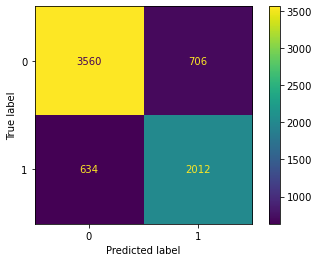

In [88]:
plot_confusion_matrix(grid_xgboost, X_test, y_test)  
plt.show()

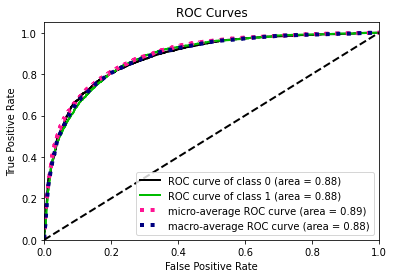

In [89]:
y_probas=grid_xgboost.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

These results are good with an AUC of 0.88 and F1 score of 0.84 for Class 0(Majority Class) and 0.75 for Class 1(Minority Class). They can be used as a Minimum Viable Model to perform Predictions on future data